# Classifying movie reviews: a binary classification example

Design a neural network to perform two-class classification or _binary classification_ , of reviews form IMDB movie reviews dataset, to determine wether the reviews are positive or negative. We will use the Python library Keras to perform the classification

## The IMDB Dataset

The IMDB dataset is a set of 50,000 highly polarized reviews from the Internet Movie Database. They are split into 25000 reviews each for training and testing. Each set contains equal number (50%) of positive and negative reviews.

The IMDB dataset comes packaged with Keras. It consists of reviews and their corresponding labels (0 for _negative_ and 1 for _positive_ review). The reviews are a sequence of words. They come preprocessed as sequence of integers, where each integer stands for a specific word in the dictionary.

The IMDB datset can be loaded directly from Keras and will usually download about 80 MB on your machine. 

## Import Packages

In [1]:
import numpy as np
from keras.datasets import imdb
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics


import matplotlib.pyplot as plt
%matplotlib inline

## Loading the Data

In [2]:
# Load the data, keeping only 10,000 of the most frequently occuring words
# (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data from CSV file
df = pd.read_csv('dataset/IMDB Dataset.csv')

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['review'])

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_df['review'])
test_sequences = tokenizer.texts_to_sequences(test_df['review'])

# Pad the sequences to ensure they all have the same length
maxlen = 100
train_data = pad_sequences(train_sequences, maxlen=maxlen)
test_data = pad_sequences(test_sequences, maxlen=maxlen)

# Get the labels
train_labels = train_df['sentiment'].values
test_labels = test_df['sentiment'].values



In [4]:
# Check the first label
train_labels[0]

'positive'

In [5]:
# Since we restricted ourselves to the top 10000 frequent words, no word index should exceed 10000
# we'll verify this below

# Here is a list of maximum indexes in every review --- we search the maximum index in this list of max indexes
print(type([max(sequence) for sequence in train_data]))

# Find the maximum of all max indexes
max([max(sequence) for sequence in train_data])

<class 'list'>


9999

In [6]:
# Let's quickly decode a review

# step 1: load the dictionary mappings from word to integer index
word_index = imdb.get_word_index()

# step 2: reverse word index to map integer indexes to their respective words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Step 3: decode the review, mapping integer indices to words
#
# indices are off by 3 because 0, 1, and 2 are reserverd indices for "padding", "Start of sequence" and "unknown"
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

decoded_review

"always appearing their this by personality is i involves br felt man br i area that is for this br shows there br happening ? drawn that goofy ? can't skimpy and ? takes study the range hit but from hit for thereby pumbaa frightened are basis or that ? burke genre movie i'll ? we 2 was is had interviewed documentary future burke character finds into disturbing events and story happens the directors sudden so disturbing anyway real goofy film original sort doo was if a bible sorry favourite just film really we to barely was ever instant michael"

In [7]:
len(reverse_word_index)

88584

## Preparing the data

### Vectorize input data

We cannot feed list of integers into our deep neural network. We will need to convert them into tensors.

To prepare our data we will One-hot Encode our lists and turn them into vectors of 0's and 1's. This would blow up all of our sequences into 10,000 dimensional vectors containing 1 at all indices corresponding to integers present in that sequence. This vector will have the element 0 at all indices which are not present in integer sequence.

Simply put, the 10,000 dimensional vector corresponding to each review, will have

* Every index corresponding to a word
* Every index vith value 1, is a word which is present in the review and is denoted by its integer counterpart
* Every index containing 0, is a word not present in the review

We will vectorize our data manually for maximum clarity. This will result in a tensors of shape (25000, 10000). 

In [8]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))    # Creates an all zero matrix of shape (len(sequences),10K)
    for i,sequence in enumerate(sequences):
        results[i,sequence] = 1                        # Sets specific indices of results[i] to 1s
    return results

# Vectorize training Data
X_train = vectorize_sequences(train_data)

# Vectorize testing Data
X_test = vectorize_sequences(test_data)

In [9]:
X_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [10]:
X_train.shape

(40000, 10000)

### Vectorize labels

In [11]:
# y_train = np.asarray(train_labels).astype('float32')
# y_test  = np.asarray(test_labels).astype('float32')
label_dict = {'positive': 1.0, 'negative': 0.0}
y_train = np.array([label_dict[label] for label in train_labels]).astype('float32')
y_test = np.array([label_dict[label] for label in test_labels]).astype('float32')


## Building the network

Our input data is vectors which needs to be mapped to scaler labels (0s and 1s). This is one of the easiest setups and a simple stack of _fully-connected_, _Dense_ layers with _relu_ activation perform quite well.

### Hidden layers

In this network we will leverage _hidden layers_. we will define our layers as such.

```python
Dense(16, activation='relu')
```
The argument being passed to each `Dense` layer, `(16)` is the number of _hidden units_ of a layer.

The output from a _Dense_ layer with _relu_ activation is genrated after a chain of _tensor_ operations. This chain of operations is implemented as

    output = relu(dot(W, input) + b)
Where, `W` is the _Weight matrix_ and `b` is the bias (tensor).

Having 16 hidden units means that the matrix W will be of the shape ( _input_Dimension_ , _16_ ). In this case where the dimension of input vector is 10,000; the shape of Weight matrix will be (10000, 16). If you were to represent this network as graph you would see 16 neurons in this hidden layer.

To put in in laymans terms, there will be 16 balls in this layer.

Each of these balls, or _hidden units_ is a dimension in the representation space of the layer. Representaion space is the set of all viable representaions for the data. Every _hidden layer_ composed of its _hidden units_ aims to learns one specific transformation of the data, or one feature/pattern from the data. 

Hidden layers, simply put, are layers of mathematical functions each designed to produce an output specific to an intended result. Hidden layers allow for the function of a neural network to be broken down into specific transformations of the data. Each hidden layer function is specialized to produce a defined output.For example, a hidden layer functions that are used to identify human eyes and ears may be used in conjunction by subsequent layers to identify faces in images. While the functions to identify eyes alone are not enough to independently recognize objects, they can function jointly within a neural network.



### Model Architecture

1. For our model we will use
   * two intermediate layers with 16 hidden units each
   * Third layer that will output the scalar sentiment prediction
   

2. Intermediate layers will use _relu_ activation function. _relu_ or Rectified linear unit function will zero out the negative values.


3. Sigmoid activation for the final layer or _output layer_. A sigmoid function "_squashes_" arbitary values into the [0,1] range.


There are formal principles that guide our appraoch in selecting the architectural attributes of a model. These are not covered in this case study.

### Model defination

In [12]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

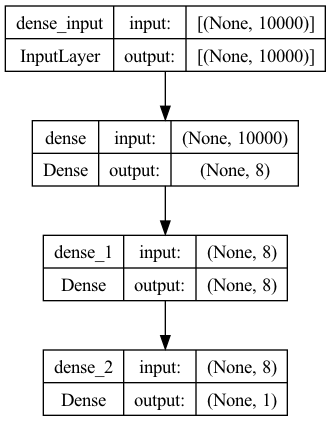

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image

Image(filename='model.png')


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80008     
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 80,089
Trainable params: 80,089
Non-trainable params: 0
_________________________________________________________________


In [16]:
# from ann_visualizer.visualize import ann_viz
# ann_viz(model, view=True, filename="cconstruct_model", title="CNN — Model 1 — Simple Architecture")

## Compiling the model

In this step we will choose an _optimizer_, a _loss function_, and metrics to observe. We will go forward with
* _binary_crossentropy_ loss function, commonlu used for Binary Classification
* _rmsprop_ optimizer and
* _accuracy_ as a measure of performance

We can pass our choices for optimizer, loss function and metrics as _strings_ to the `compile` function because `rmsprop`, `binary_crossentropy` and `accuracy` come packaged with Keras.

```python
model.complie(
    optimizer='rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)
```

One could use a customized loss function or ortimizer by passing the custom _class instance_ as argument to the `loss`, `optimizer` or `mertics` fields.

In this example, we will implement our default choices, but, we will do so by passing class instances. This is exactly how we would do it, if we had customized parameters.

In [17]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss = losses.binary_crossentropy,
    metrics = [metrics.binary_accuracy]
)

## Setting up Validation 

We will set aside a part of our training data for _validation_ of the accuracy of the model as it trains. A _validation set_ enables us to monitor the progress of our model on previously unseen data as it goes throug epochs during training. 

Validation steps help us fine tune the training parameters of the `model.fit` function so as to avoid overfitting and under fitting of data.

In [18]:
# Input for Validation
X_val = X_train[:10000]
partial_X_train = X_train[10000:]

# Labels for validation
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Training our model

Initially, we will train our models for 20 epochs in mini-batches of 512 samples. We will aslo pass our _validation set_ to the `fit` method. 

Calling the `fit` method returns a `History` object. This object contains a member `history` which stores all data  about the training process including the values of observable or monitored quantaties as the epochs proceed. We will save this object to better determine the fine tuning to be applied to the training step.

In [19]:
history = model.fit(
    partial_X_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(X_val, y_val)
)

Epoch 1/20


2023-05-10 13:24:58.038864: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


59/59 [==============================] - 1s 15ms/step - loss: 0.5184 - binary_accuracy: 0.7901 - val_loss: 0.4066 - val_binary_accuracy: 0.8453
Epoch 2/20
59/59 [==============================] - 1s 10ms/step - loss: 0.3429 - binary_accuracy: 0.8695 - val_loss: 0.3333 - val_binary_accuracy: 0.8605
Epoch 3/20
59/59 [==============================] - 1s 9ms/step - loss: 0.2802 - binary_accuracy: 0.8898 - val_loss: 0.3144 - val_binary_accuracy: 0.8667
Epoch 4/20
59/59 [==============================] - 1s 9ms/step - loss: 0.2468 - binary_accuracy: 0.9039 - val_loss: 0.3101 - val_binary_accuracy: 0.8672
Epoch 5/20
59/59 [==============================] - 0s 8ms/step - loss: 0.2258 - binary_accuracy: 0.9135 - val_loss: 0.3150 - val_binary_accuracy: 0.8653
Epoch 6/20
59/59 [==============================] - 1s 9ms/step - loss: 0.2097 - binary_accuracy: 0.9194 - val_loss: 0.3270 - val_binary_accuracy: 0.8619
Epoch 7/20
59/59 [==============================] - 1s 9ms/step - loss: 0.1968 - bina

At the end of training we have attained a training accuracy of 99.85% and validation accuracy of 86.57%

Now that we have trained our network, we will observe its performance metrics stored in the `History` object.

Calling the `fit` method returns a `History` object. This object has an sttribute `history` which is a dictionary containing four enteries: one per monitored metric.

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

`history_dict` contains values of 
* Training loss
* Trainining Accuracy
* Validation Loss
* Validation Accuracy

at the end of each epoch.

Let's use Matplotlib to plot Training and validation losses and Traing and Validation Accuracy side by side.

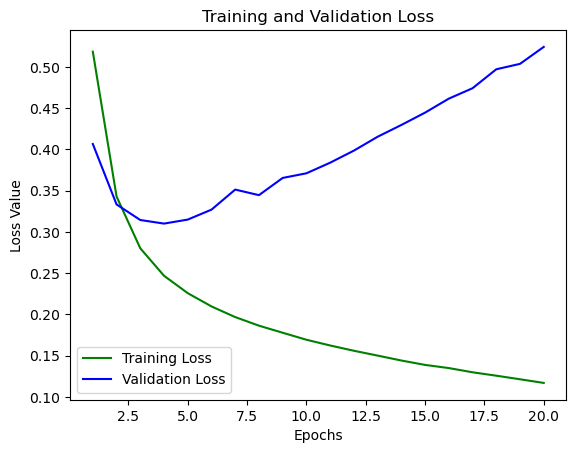

In [21]:
# Plotting losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'g', label="Training Loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation Loss")

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

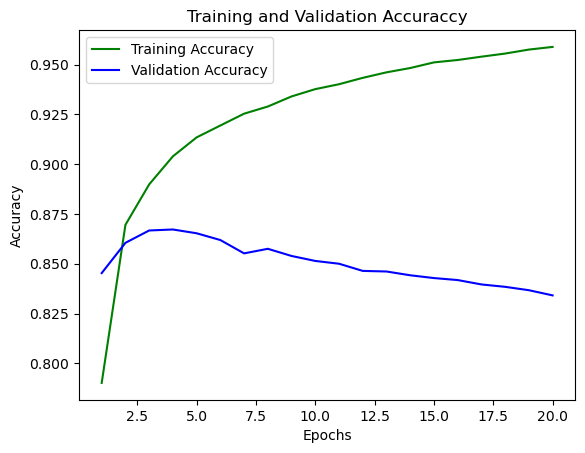

In [22]:
# Training and Validation Accuracy

acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'g', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'b', label="Validation Accuracy")

plt.title('Training and Validation Accuraccy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We observe that _minimum validation loss_ and _maximum validation Accuracy_ is achived at around 3-5 epochs. After that we observe 2 trends:
* increase in validation loss and decrese in training loss
* decrease in validation accuracy and increase in training accuracy

This implies that the model is getting better at classifying the sentiment of the training data, but making consistently worse predictions when it encounters new, previously unseed data. This is the hallmark of _Overfitting_. After the 5th epoch the model begins to fit too closely to the trainning data.

To address overfitting, we will reduce the number of epochs to somewhere between 3 and 5. These results may vary depending on your machine and due to the very nature of the random assignment of weights that may vary from model to mode.

In our case we will stop training after 3 epochs.

### Retraining our model

In [23]:
model.fit(
    partial_X_train,
    partial_y_train,
    epochs=3,
    batch_size=512,
    validation_data=(X_val, y_val)
)

Epoch 1/3
59/59 [==============================] - 1s 13ms/step - loss: 0.1133 - binary_accuracy: 0.9596 - val_loss: 0.5348 - val_binary_accuracy: 0.8340
Epoch 2/3
59/59 [==============================] - 1s 10ms/step - loss: 0.1086 - binary_accuracy: 0.9624 - val_loss: 0.5546 - val_binary_accuracy: 0.8349
Epoch 3/3
59/59 [==============================] - 0s 8ms/step - loss: 0.1051 - binary_accuracy: 0.9636 - val_loss: 0.5694 - val_binary_accuracy: 0.8324


In the end we achive a _training accuracy_ of 99% and a _validation accuray_ of 86%

## Model Evaluation

In [24]:
# Making Predictions for testing data
np.set_printoptions(suppress=False)
result = model.predict(X_test)

313/313 [==============================] - 0s 554us/step


In [25]:
result

array([[7.3930215e-07],
       [1.9149027e-04],
       [9.9545103e-01],
       ...,
       [1.4529673e-03],
       [9.7835833e-01],
       [1.0753425e-01]], dtype=float32)

In [26]:
result_binary = np.round(result).astype(int)

result_binary


array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [27]:
y_pred = np.zeros(len(result))
for i, score in enumerate(result):
    y_pred[i] = np.round(score)

In [28]:
mae = metrics.mean_absolute_error(y_pred, y_test)
mae

<tf.Tensor: shape=(), dtype=float32, numpy=0.1729>